# Set up

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd '/content/drive/MyDrive/programming projects/SAM'

/content/drive/MyDrive/programming projects/SAM


In [3]:
!pwd

/content/drive/MyDrive/programming projects/SAM


In [4]:
import os

import cv2
import torch
import requests
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from io import BytesIO
from torchvision.transforms import Compose

from depth_anything.dpt import DepthAnything
from depth_anything.util.transform import Resize, NormalizeImage, PrepareForNet

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

In [5]:
def get_image_from_url(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert("RGB")
    return np.array(img)

def get_image_from_files(dir):
  images_list = list()
  for root, dirs, files in os.walk(dir):
    for file in files:
      images_list.append(dir+file)
  print(f'There are {len(images_list)} images in our dataset')
  return images_list

dir = "images_input/"
images_list = get_image_from_files(dir)

There are 10 images in our dataset


In [6]:
!pip install git+https://github.com/facebookresearch/segment-anything.git

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-mb__aw6q
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-mb__aw6q
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done


In [7]:
!pip install opencv-python pycocotools matplotlib onnxruntime onnx

In [8]:
from IPython.display import display, HTML
display(HTML(
"""
<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
"""
))

In [9]:
using_colab = False # Using colab but have downloaded sam_vit_h_4b8939.pth, set false
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

    !mkdir images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg

    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

# Obtain Depth

In [10]:
raw_image = cv2.imread(images_list[6])
raw_image = cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB) / 255.0

In [11]:
encoder = 'vits' # can also be 'vits', 'vitb' or 'vitl'

transform = Compose([
    Resize(
        width=518,
        height=518,
        resize_target=False,
        keep_aspect_ratio=True,
        ensure_multiple_of=14,
        resize_method='lower_bound',
        image_interpolation_method=cv2.INTER_CUBIC,
    ),
    NormalizeImage(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    PrepareForNet(),
])

depth_anything = DepthAnything.from_pretrained('LiheYoung/depth_anything_{:}14'.format(encoder)).eval()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [12]:
%%time
image_resized = transform({'image': raw_image})['image']
image_resized = torch.from_numpy(image_resized).unsqueeze(0)

depth = depth_anything(image_resized)  # depth shape: 1xHxW
depth = depth.detach().squeeze()

CPU times: user 4.85 s, sys: 2.58 s, total: 7.42 s
Wall time: 2.1 s


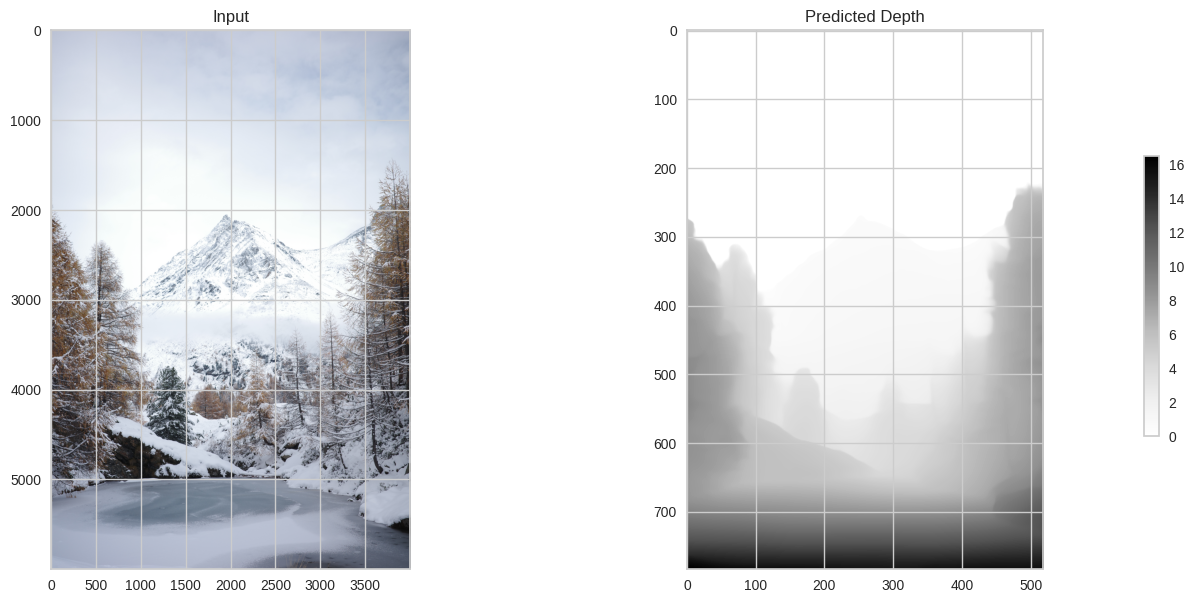

In [13]:
plt.figure(figsize=(15,7))

plt.subplot(121)
plt.title('Input')
plt.imshow(raw_image)

plt.subplot(122)
plt.title('Predicted Depth')
plt.imshow(depth)

plt.colorbar(cax = plt.axes([0.91, 0.3, 0.01, 0.4]))

# Automatic segmentation of all objects

In [14]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

## Functions

In [15]:
from viz import show_anns, show_all_segmts_ind, save_layers
from cut import assign2layers_kmeans
from process_seg_img import downsample_image_opencv, obtain_all_objects,check_overlapping

## Procedure

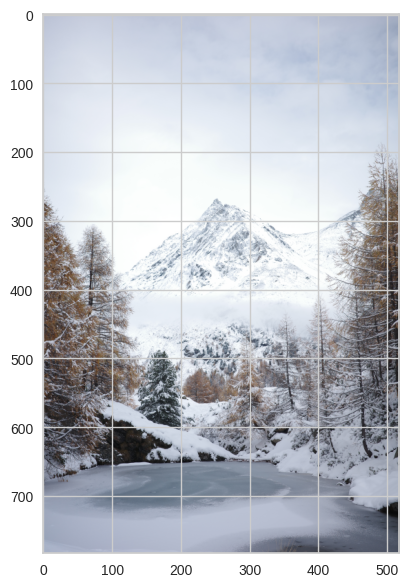

In [16]:
# Dowsample the original image
img_lr = downsample_image_opencv(raw_image, depth.shape)
plt.figure(figsize=(15,7))
plt.imshow(img_lr)
plt.show()

In [17]:
object_masks = obtain_all_objects(mask_generator, img_lr)

Iteration n=1: white pixel raito after segmentation = 0.8099809904656844, difference =0.5708927347868457
Iteration n=2: white pixel raito after segmentation = 0.9786487471436451, difference =0.22893807388617177


In [18]:
check_overlapping(object_masks)

There is no overlap


There is 13 object masks


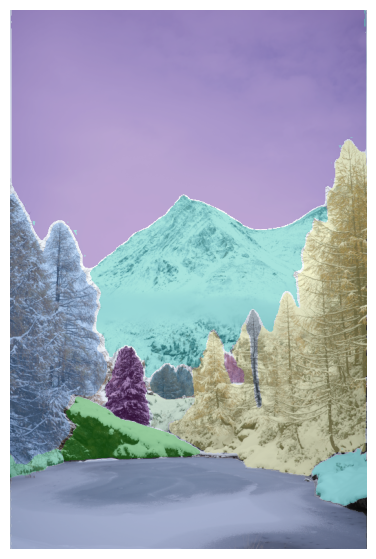

In [19]:
print(f"There is {len(object_masks)} object masks")
plt.figure(figsize=(15,7))
plt.imshow(img_lr)
show_anns(object_masks)
plt.axis('off')
plt.show()

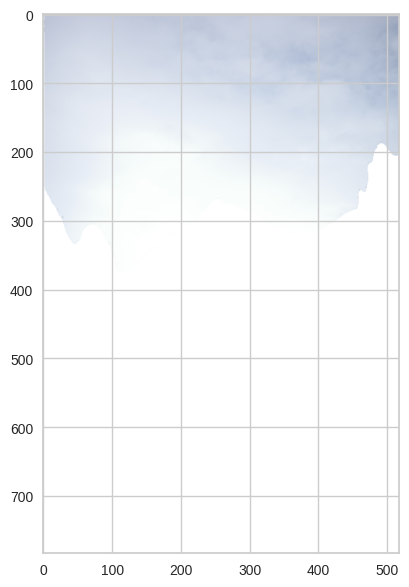

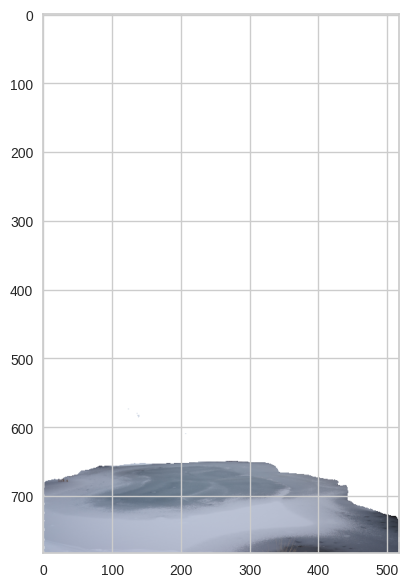

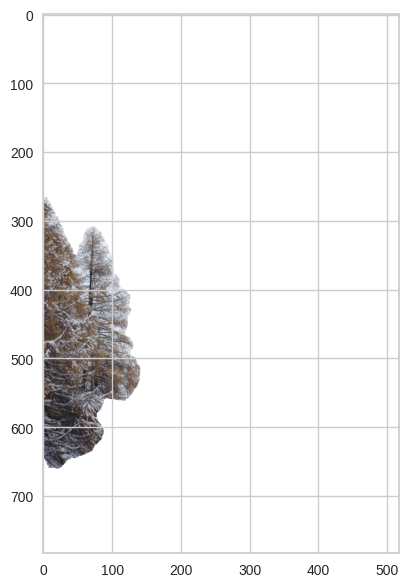

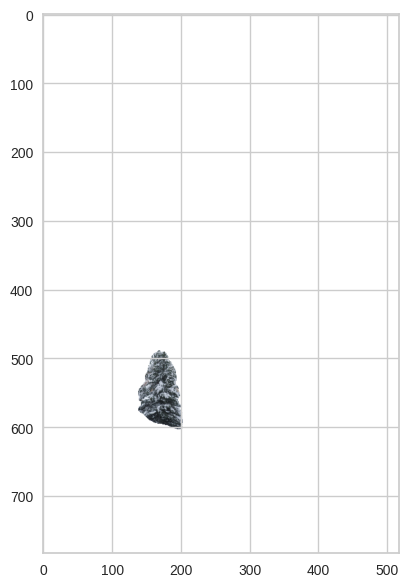

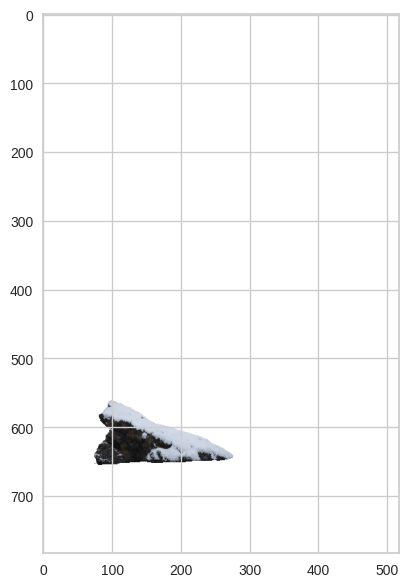

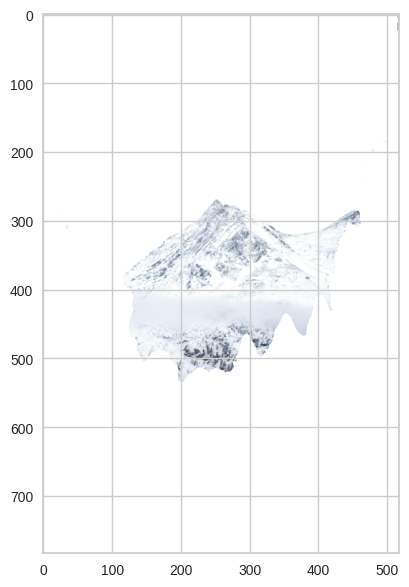

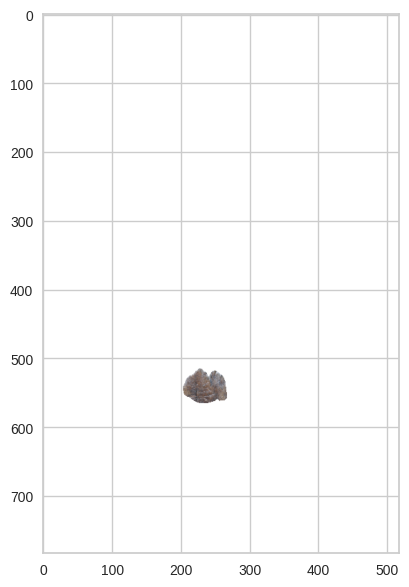

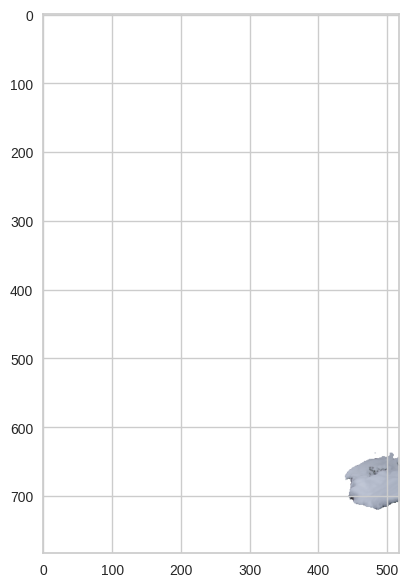

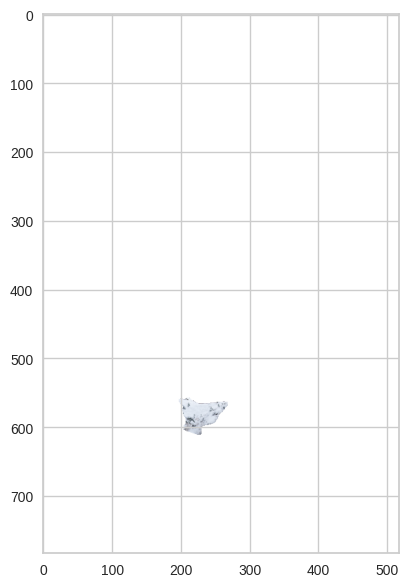

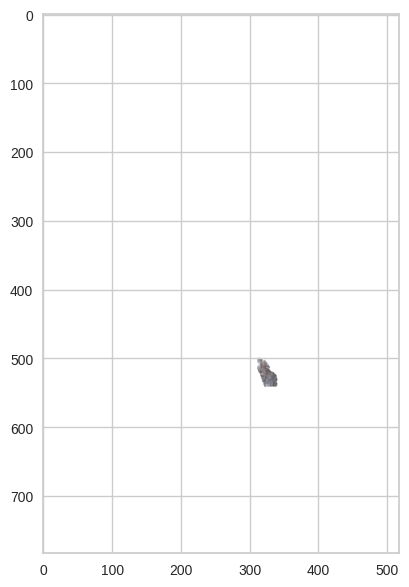

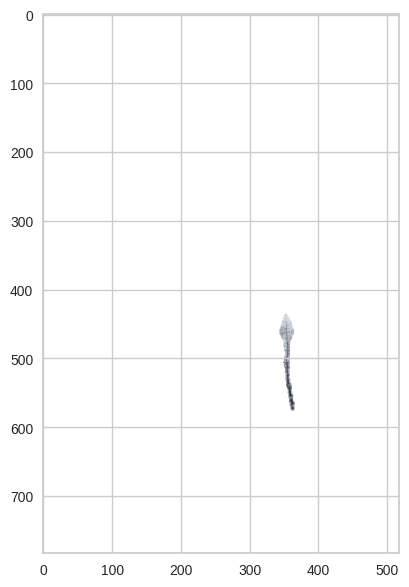

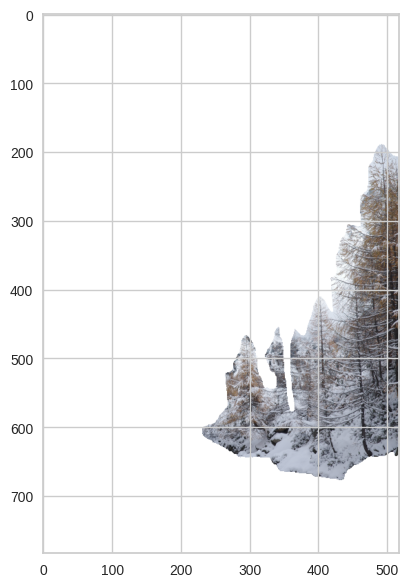

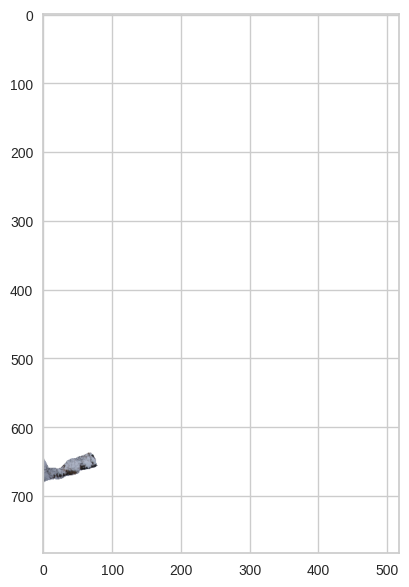

In [20]:
show_all_segmts_ind(object_masks, img_lr)

# Assign objects to layers based on depth

In [36]:
layers_idx, layers = assign2layers_kmeans(object_masks, depth.numpy(), 3)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


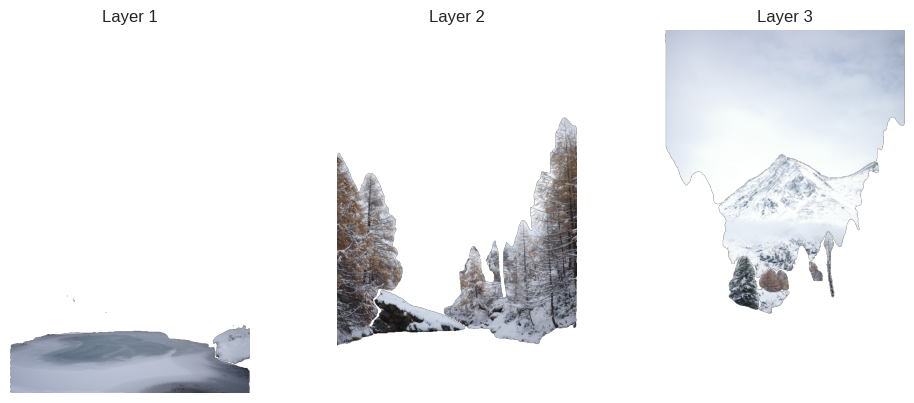

In [37]:
save_layers(img_lr, object_masks, layers_idx, ['images_output/layer1.png','images_output/layer2.png','images_output/layer3.png'])


---





---

